In [ ]:
%pip install sentence-transformers

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from scipy.stats import ttest_ind

In [ ]:
path_data = "data/"
# Load the sentence embeddings DataFrame
df = pd.read_pickle(path_data+"df_sentenceembeddings.pkl")

In [ ]:
# Calculate the top 10% authors who publish the most
top_10_percent_authors = df['author_id'].value_counts().nlargest(int(len(df['author_id'].unique()) * 0.1)).index

# Filter the DataFrame based on the top 10% authors
df_top_10_percent = df[df['author_id'].isin(top_10_percent_authors)]

# Function to filter authors based on the new condition
def filter_activists(df):
    # Get the number of unique months each author has posted in
    author_post_months = df.groupby('author_id')['created_at'].apply(lambda x: x.dt.month.nunique())

    # Filter authors who have posted in every month
    prolific_authors = author_post_months[author_post_months >= 8].index

    # Filter the DataFrame based on prolific authors
    df_activists = df[df['author_id'].isin(prolific_authors)]

    return df_activists

# Apply the prolific condition to the original DataFrame
df_activists = filter_activists(df_top_10_percent)

# Define the start date (July 12th, 2021)
start_date = '2021-28'

# Get the first post date for each author in the entire dataset
first_post_dates = df.groupby('author_id')['week'].min()

# Identify authors who first posted on July 12th, 2021
first_post_july_12th = first_post_dates[first_post_dates == start_date].index

# Filter the dataset to include only authors who first posted on July 12th, 2021
authors_started_on_july_12th_df = df[df['author_id'].isin(first_post_july_12th)]

# Filter the dataset to include only authors who continued posting after July 12th, 2021
#authors_posted_after_july_12th = authors_posted_on_july_12th[authors_posted_on_july_12th['week'] > start_date]

# Filter the data to include only authors who posted after July 12th, 2021
#filtered_df_posted_after_july_12th = df[df['author_id'].isin(authors_posted_after_july_12th['author_id'])]

# Define the function to filter authors based on the new condition
def filter_authors_stopped(df, first_post_july_12th):
    # Get the last post date for each author in the entire dataset
    last_post_dates = df.groupby('author_id')['week'].max()

    # Identify authors who first posted on 2021-28 and never posted after
    last_post_july_12th = last_post_dates[last_post_dates == '2021-28'].index
    first_last_post_july_12th = list(set(last_post_july_12th).intersection(set(first_post_july_12th)))

    # Filter the dataset to include only authors who first posted on 2021-28 and never posted after
    authors_stopped_df = df[df['author_id'].isin(first_last_post_july_12th)]

    return authors_stopped_df

# Apply the new condition to the original DataFrame
authors_stopped_df = filter_authors_stopped(df, first_post_july_12th)

# Get the index of authors to be removed
authors_to_remove_index = authors_started_on_july_12th_df[authors_started_on_july_12th_df['author_id'].isin(authors_stopped_df['author_id'])].index

# Remove authors from authors_posted_on_july_12th
authors_continued_df = authors_started_on_july_12th_df.drop(authors_to_remove_index)

# Get the list of all author IDs in the DataFrame
all_authors = df['author_id'].unique()

# Get the list of authors who are prolific
activists_list = df_activists['author_id'].unique()

# Get the list of authors who started but did not continue
stopped_authors_list = authors_stopped_df['author_id'].unique()

# Get the list of authors who started and continue
continued_authors_list = authors_continued_df['author_id'].unique()

# # Create a list of authors not included in any of the other groups
# other_authors_list = [author for author in all_authors if author not in activists_list
#                       and author not in stopped_authors_list and author not in continued_authors_list]

# # Filter the DataFrame to include only authors in the "other" group
# df_other_authors = df[df['author_id'].isin(other_authors_list)]

# Step 1: Identify authors who started posting before 2021-28
authors_started_before_july_12th = first_post_dates[first_post_dates < '2021-28'].index

# Step 2: Ensure these authors are not part of the activists, stopped, or continued groups
# Create a set of authors who are not activists, stopped, or continued
excluded_authors = set(activists_list).union(stopped_authors_list).union(continued_authors_list)

# Filter out authors who are in the excluded groups
other_authors_list = [author for author in authors_started_before_july_12th if author not in excluded_authors]

# Step 3: Filter the DataFrame to include only authors in the "other" group
df_other_authors = df[df['author_id'].isin(other_authors_list)]

In [ ]:
# Define the start date (the week after Macron's speech, e.g., week '2021-28')
week_after_macron_speech = '2021-29'

# Identify authors who first posted in the week after Macron's speech
authors_started_after_macron = first_post_dates[first_post_dates >= week_after_macron_speech].index

# Count the number of unique authors who started posting in the week after Macron's speech
num_authors_started_after_macron = len(authors_started_after_macron)

print(f"Number of authors who started posting the week after Macron's speech: {num_authors_started_after_macron}")

Number of authors who started posting the week after Macron's speech: 12269


In [ ]:
print(len(activists_list), len(stopped_authors_list), len(continued_authors_list), len(other_authors_list))

817 3321 2068 8541


In [ ]:
path_folder = ""

0.49146807 0.36770138
T-test between 'Established Core' and 'Established Irregular': Statistic=231.21570204888553, p-value=0.0


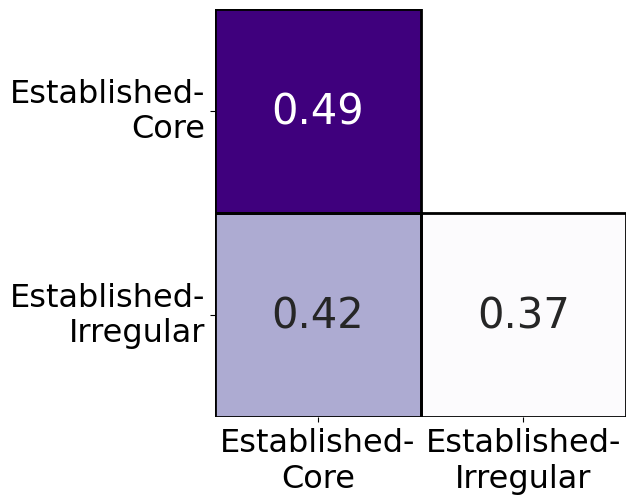

In [ ]:
# Function to calculate similarity between sentence embeddings of different groups
def calculate_similarity(sentence_embeddings_group1, sentence_embeddings_group2):
    similarity_matrix = cosine_similarity(sentence_embeddings_group1, sentence_embeddings_group2)

    num_samples = similarity_matrix.size - (similarity_matrix.shape[0] if np.array_equal(sentence_embeddings_group1, sentence_embeddings_group2) else 0)
    sum_similarity = similarity_matrix.sum() - (np.trace(similarity_matrix) if np.array_equal(sentence_embeddings_group1, sentence_embeddings_group2) else 0)

    average_similarity = sum_similarity / num_samples
    return average_similarity, similarity_matrix

# Function to get user centroids for a given week
def get_user_centroids(df, week):
    week_df = df[df['week'] == week]
    return week_df.groupby('author_id')['embeddings'].apply(
        lambda x: torch.stack([torch.tensor(item) for item in x]).mean(dim=0)).reset_index()

# Function to convert tensor centroids to numpy arrays
def convert_to_numpy(user_centroids):
    user_centroids_np = [centroid.numpy() for centroid in user_centroids["embeddings"].values if centroid.numel() > 1]
    return torch.tensor(user_centroids_np).numpy()

# Function to analyze similarities and perform t-tests
def analyze_groups(user_centroids_np, group_indices):
    means = np.zeros((len(group_indices), len(group_indices)))

    for i in range(len(group_indices)):
        for j in range(len(group_indices)):
            if i == j:
                means[i, j], _ = calculate_similarity(user_centroids_np[group_indices[i]], user_centroids_np[group_indices[i]])
            else:
                _, similarity_matrix = calculate_similarity(user_centroids_np[group_indices[i]], user_centroids_np[group_indices[j]])
                means[i, j] = similarity_matrix.mean()

    return means

# Function to generate heatmap
def plot_heatmap(heatmap_data, group_names, week):
    mask = np.triu(np.ones_like(heatmap_data, dtype=bool), k=1)
    staggered_group_names = [name.replace(" ", "-\n") for name in group_names]
    # Adjust the size of the figure based on the number of groups
    num_groups = len(group_names)

    # Ensure that the cells are square by adjusting the figure size
    plt.figure(figsize=(num_groups * 2.65, num_groups * 2.65))  # Scale size with the number of groups

    sns.heatmap(heatmap_data, annot=True, cmap='Purples', fmt=".2f",
                xticklabels=staggered_group_names, yticklabels=staggered_group_names,
                annot_kws={"size": 30}, mask=mask, cbar=False)

    for (i, j), val in np.ndenumerate(mask):
        if val:  # If the cell is masked
            continue
        else:
          plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))


    #plt.title(f'Week {week}', fontsize=40)
    plt.yticks(fontsize=23, rotation=0)
    plt.xticks(ha='center', fontsize=23, rotation_mode="anchor")

    #plt.tight_layout(pad=0)
    plt.savefig(path_folder+f'figures/heatmap_week_{week}_8months.png', dpi=200, bbox_inches="tight")
    plt.show()

# Main function to run the analysis for a given week
def run_week_analysis(df, week, group_data):
    # Get user centroids for the given week
    user_centroids_week = get_user_centroids(df, week)

    # Convert centroids to numpy array
    user_centroids_np = convert_to_numpy(user_centroids_week)

    # Extract group indices
    group_indices = [user_centroids_week[user_centroids_week.author_id.isin(group)].index for group in group_data['groups']]

    # Perform similarity analysis
    heatmap_data = analyze_groups(user_centroids_np, group_indices)

    # Perform t-tests between all groups using the flattened similarity matrices
    t_test_results = []
    for i in range(len(group_indices)):
        for j in range(i + 1, len(group_indices)):
            sim_i = cosine_similarity(user_centroids_np[group_indices[i]])
            sim_j = cosine_similarity(user_centroids_np[group_indices[j]])
            print(sim_i.flatten().mean(), sim_j.flatten().mean())
            t_stat, p_val = ttest_ind(sim_i.flatten(), sim_j.flatten())
            t_test_results.append((group_data['names'][i], group_data['names'][j], t_stat, p_val))

    # Print t-test results
    for name1, name2, t_stat, p_val in t_test_results:
        print(f"T-test between '{name1}' and '{name2}': Statistic={t_stat}, p-value={p_val}")

    # Plot heatmap
    plot_heatmap(heatmap_data, group_data['names'], week)

# Example usage
group_data_week_27 = {
    'groups': [set(df_activists['author_id']), set(other_authors_list)],
    'names': ['Established Core', 'Established Irregular']
}

run_week_analysis(df, '2021-27', group_data_week_27)

0.5735377 0.42425376
0.5735377 0.40475518
0.5735377 0.31356838
0.42425376 0.40475518
0.42425376 0.31356838
0.40475518 0.31356838
T-test between 'Established Core' and 'Established Irregular': Statistic=550.9070858107796, p-value=0.0
T-test between 'Established Core' and 'Incoming Persistent': Statistic=655.4019892146894, p-value=0.0
T-test between 'Established Core' and 'Incoming Transient': Statistic=1074.1068370282362, p-value=0.0
T-test between 'Established Irregular' and 'Incoming Persistent': Statistic=164.5594118164549, p-value=0.0
T-test between 'Established Irregular' and 'Incoming Transient': Statistic=1159.4370749845627, p-value=0.0
T-test between 'Incoming Persistent' and 'Incoming Transient': Statistic=979.0804577776877, p-value=0.0


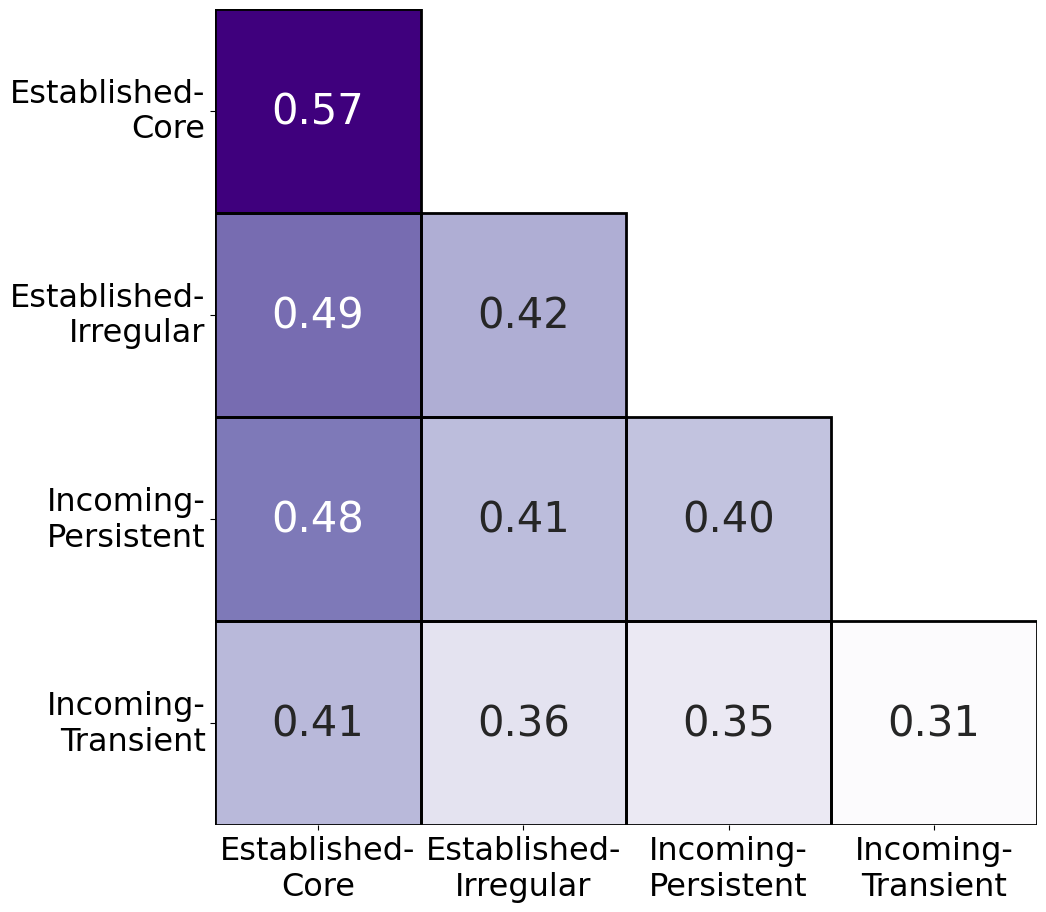

In [ ]:
# Example usage
group_data_week_28 = {
    'groups': [
        set(df_activists['author_id']),
        set(other_authors_list),
        set(authors_continued_df['author_id']),
        set(authors_stopped_df['author_id'])
    ],
    'names': ['Established Core', 'Established Irregular', 'Incoming Persistent', 'Incoming Transient']
}

run_week_analysis(df, '2021-28', group_data_week_28)

0.60662526 0.45515436
0.60662526 0.46405408
0.45515436 0.46405408
T-test between 'Established Core' and 'Established Irregular': Statistic=595.127815821873, p-value=0.0
T-test between 'Established Core' and 'Incoming Persistent': Statistic=511.8837249899562, p-value=0.0
T-test between 'Established Irregular' and 'Incoming Persistent': Statistic=-50.2586720029455, p-value=0.0


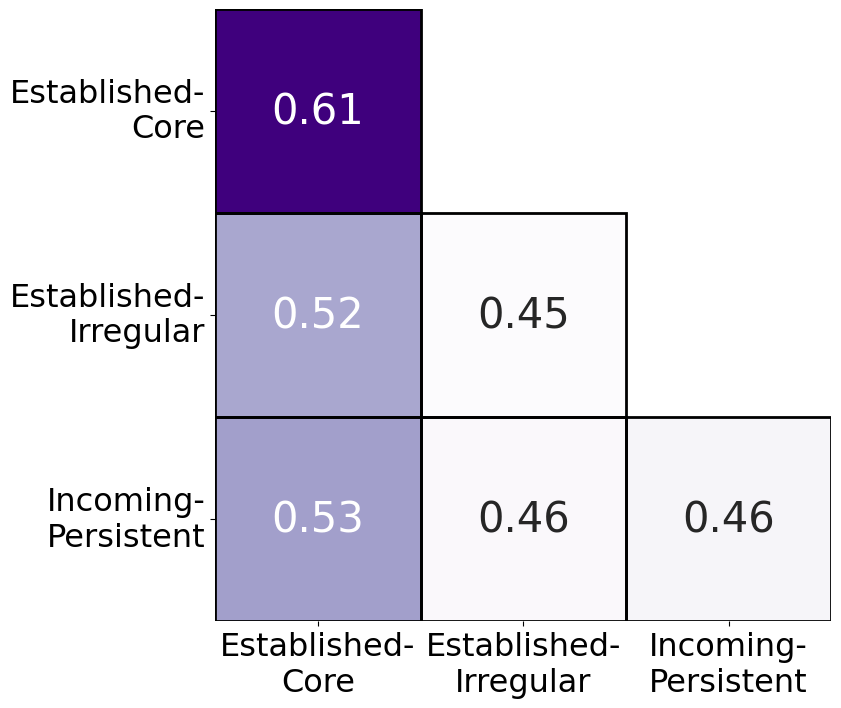

In [ ]:
# Example usage
group_data_week_29 = {
    'groups': [set(df_activists['author_id']), set(other_authors_list),
              set(authors_continued_df['author_id'])],
    'names': ['Established Core', 'Established Irregular', 'Incoming Persistent']
}

run_week_analysis(df, '2021-29', group_data_week_29)